## Does not make sense

Cannot be finetuned with all 4 losses. The term 1 and term 4 are contradictory.

In [1]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:5')
else:
    device = torch.device('cpu')
    
print(device)
device = torch.device('cpu')

cpu


In [3]:
# the deep neural network
class MLP(torch.nn.Module):
    def __init__(self, layers, activation="relu", init="xavier"):
        super(MLP, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "tanh":
            self.activation = torch.nn.Tanh()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()
        else:
            raise ValueError("Unspecified activation type")
        
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        if init=="xavier":
            self.xavier_init_weights()
        elif init=="kaiming":
            self.kaiming_init_weights()
    
    def xavier_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Xavier Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.0)

    def kaiming_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Kaiming Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.kaiming_uniform_(m.weight)
                    m.bias.data.fill_(0.0)
                        
    def forward(self, x):
        out = self.layers(x)
        return out
    
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X
        
    def __getitem__(self, index):
        return self.X[index]
    
    def __len__(self):
        return len(self.X)

In [4]:
data_df = pd.read_csv("./../02_training/all_data_lake_modeling_in_time.csv")
time = data_df['time']
data_df = data_df.drop(columns=['time'])
data_df
display(data_df.head)

<bound method NDFrame.head of          depth  AirTemp_degC  Longwave_Wm-2  Latent_Wm-2  Sensible_Wm-2  \
0            1    -19.719746     471.661536  -101.200398    -231.960902   
1            2    -19.719746     471.661536  -101.200398    -231.960902   
2            3    -19.719746     471.661536  -101.200398    -231.960902   
3            4    -19.719746     471.661536  -101.200398    -231.960902   
4            5    -19.719746     471.661536  -101.200398    -231.960902   
...        ...           ...            ...          ...            ...   
1752345     46    -12.920028     494.226632   -46.982710     -95.220702   
1752346     47    -12.920028     494.226632   -46.982710     -95.220702   
1752347     48    -12.920028     494.226632   -46.982710     -95.220702   
1752348     49    -12.920028     494.226632   -46.982710     -95.220702   
1752349     50    -12.920028     494.226632   -46.982710     -95.220702   

         Shortwave_Wm-2  lightExtinct_m-1  ShearVelocity_mS-1  \
0   

In [5]:
training_frac = 0.60
depth_steps = 50
number_days = len(data_df)//depth_steps
n_obs = int(number_days*training_frac)*depth_steps
print(f"Number of days total: {number_days}")
print(f"Number of training points: {n_obs}")

Number of days total: 35047
Number of training points: 1051400


# Normalizing Data

In [6]:
data = data_df.values

train_data = data[:n_obs]
test_data = data[n_obs:]

train_time = time[:n_obs]
test_time = time[n_obs:]

#performing normalization on all the columns
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [7]:
m0_output_column_ix = [data_df.columns.get_loc(column) for column in ['temp_conv04']]

# Loading Models

In [8]:
m0_input_columns = ['depth', 'AirTemp_degC', 'Shortwave_Wm-2',
                'lightExtinct_m-1','Area_m2', 'Uw',
                 'day_of_year', 'time_of_day', 'temp_initial00'] #,  
               #  'buoyancy', 'diffusivity', 'temp_initial00', 
               # 'temp_heat01', 'temp_diff02', 'temp_total05',
               # 'ice', 'snow', 'snowice'
m0_output_columns =['temp_conv04']

m0_input_column_ix = [data_df.columns.get_loc(column) for column in m0_input_columns]
m0_output_column_ix = [data_df.columns.get_loc(column) for column in m0_output_columns]

m0_PATH =  f"./saved_models/directdeep_model_PB_finetuned.pth"
m0_layers = [len(m0_input_columns), 32, 32,32,32,32,32,32,32,32,32, len(m0_output_columns)]

direct_model = MLP(m0_layers, activation="gelu")
m0_checkpoint = torch.load(m0_PATH, map_location=torch.device('cpu'))
direct_model.load_state_dict(m0_checkpoint)
direct_model = direct_model.to(device)

Initializing Network with Xavier Initialization..


## Heat Diffusion Model

## Mixing Model

# Convection Model

# Ice Model

In [9]:
obs_temp_columns = ['obs_temp']

obs_temp_columns_ix = [data_df.columns.get_loc(column) for column in obs_temp_columns]

In [10]:
# depth_steps = 24
# train_data = np.reshape(train_data, (train_data.shape[0]//depth_steps, depth_steps, train_data.shape[1]))
# test_data = np.reshape(test_data, (test_data.shape[0]//depth_steps, depth_steps, test_data.shape[1]))

In [11]:
#keeping track of the mean and standard deviations
train_mean = scaler.mean_
train_std = scaler.scale_

In [12]:
# Create data set
batch_size = 1000

#assert batch_size % 25 ==0, "Batchsize has to be multiple of 25" 

train_dataset = DataGenerator(train_data)
test_dataset = DataGenerator(test_data)
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [13]:
print(train_data.shape)
print(test_data.shape)

(1051400, 45)
(700950, 45)


In [14]:
def rmse(true, pred):
    return (((true-pred)**2).mean()**0.5).detach().cpu().numpy()

def l2_error(true, pred):
    return np.linalg.norm(pred.detach().cpu().numpy() - true.detach().cpu().numpy()) / np.linalg.norm(true.detach().cpu().numpy()) 

In [15]:
def compute_metrics(model, loader, input_columns, output_columns, train_mean, train_std):
    model.eval()
    y_ = []
    pred_ = []
    mean = torch.tensor(train_mean[output_columns]).to(device)
    std = torch.tensor(train_std[output_columns]).to(device)
    
    for x in iter(loader):
        inputs, target = x[:, input_columns].to(device).float(), x[:, output_columns].to(device).float()
        pred = model(inputs)
        target = target * std + mean
        pred = pred * std + mean
        y_.append(target)
        pred_.append(pred)
    y_ = torch.cat(y_, dim=0) 
    pred_ = torch.cat(pred_, dim=0)
    
    if y_.shape[1]==2:
        rmse_temp = rmse(y_[:,1], pred_[:,1])
        l2_error_temp = l2_error(y_[:,1], pred_[:,1])
    else:
        rmse_temp = rmse(y_[:,0], pred_[:,0])
        l2_error_temp = l2_error(y_[:,0], pred_[:,0])
        
    return rmse_temp, l2_error_temp

In [16]:
def get_rollout_predictions(direct_model, loader, plot = True):    
    direct_model.eval()

    mean = torch.tensor(train_mean[m0_output_column_ix]).float().to(device)
    std = torch.tensor(train_std[m0_output_column_ix]).float().to(device)


#     depthwise_y_pred = []
#     depthwise_y_true = []
    y_ = []
    y_obs_ = []
    pred_ = []
        
    rmse_models = np.zeros((len(loader), 5))
    for ix, x in enumerate(iter(loader)):
        x = x.to(device).float()
        
        m0_input = x[:, m0_input_column_ix]
            
        #model 0
        m0_pred = direct_model(m0_input) #predicts diff and temp
            
        if plot:
            m0_y_true = x[:, m0_output_column_ix[0]] * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
            m0_y_pred = m0_pred * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 0] = rmse(m0_y_true.squeeze(), m0_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m0", rmse(m0_y_true.flatten(), m0_y_pred.flatten()))

        y_true = x[:, m0_output_column_ix] * std + mean
        y_obs = x[:, obs_temp_columns_ix] * train_std[obs_temp_columns_ix[0]] + train_mean[obs_temp_columns_ix[0]]
        pred = m0_pred * std + mean
        
        y_.append(y_true)
        y_obs_.append(y_obs)
        pred_.append(pred)

    y_ = torch.cat(y_, dim=0)
    y_obs_ = torch.cat(y_obs_, dim=0)
    pred_ = torch.cat(pred_, dim=0) 
    
    #if plot:   
     #        rmse_models = rmse_models.mean(axis=0)
     #        plt.figure(figsize=(12,8))
     #        plt.plot(rmse_models[:, 0], label="RMSE after Heating Model")
     #        plt.plot(rmse_models[:, 1], label="RMSE after Heat-Diffusion Model")
     #        plt.plot(rmse_models[:, 2], label="RMSE after Mixing Model")
     #        plt.plot(rmse_models[:, 3], label="RMSE after Convection Model")
     #        plt.plot(rmse_models[:, 4], label="RMSE after Ice Model")
     #        plt.legend(loc="upper left", fontsize=12)
     #        plt.xlabel("Depth", fontsize=12)
     #        plt.ylabel("RMSE", fontsize=12)
     #        plt.grid("on", alpha=0.5)
     #        plt.show()
    
    return pred_, y_, y_obs_, rmse_models


In [17]:
def plot_output(y_pred, y_true, depth_steps, time_label, figsize=(20,10)):
    time_label = np.array([time[:10] for time in time_label])
    time_label = time_label[::depth_steps]
    
    y_pred = y_pred.flatten().detach().cpu().numpy()
    y_true = y_true.flatten().detach().cpu().numpy()
    
    y_true = np.reshape(y_true, (y_true.shape[0]//depth_steps, depth_steps))
    y_pred = np.reshape(y_pred, (y_pred.shape[0]//depth_steps, depth_steps))
    
    N_pts = 6 # number of points to display on the x-label
    
    fig, ax = plt.subplots(3, 1, figsize=figsize)
    sns.heatmap(y_true.T, ax=ax[0], cmap='Spectral_r', vmin=0., vmax=35.)
    ax[0].set_ylabel("Depth", fontsize=15)
    ax[0].set_xlabel("Time", fontsize=15)
    
    xticks_ix = np.array(ax[0].get_xticks()).astype(int)
    time_label = time_label[xticks_ix]
    nelement = len(time_label)//N_pts
    time_label = time_label[::nelement]
    ax[0].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[0].set_xticklabels(time_label, rotation=0)   
#     ax[0].xaxis.set_major_locator(plt.MultipleLocator(100))
    ax[0].collections[0].colorbar.set_label("Actual Temperature")
    
    sns.heatmap(y_pred.T, ax=ax[1], cmap='Spectral_r', vmin=0., vmax=35.)
    ax[1].set_ylabel("Depth", fontsize=15)
    ax[1].set_xlabel("Time", fontsize=15)
    ax[1].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[1].set_xticklabels(time_label, rotation=0)
    ax[1].collections[0].colorbar.set_label("Predicted Temperature")
    
    sns.heatmap(np.abs(y_pred.T-y_true.T), ax=ax[2], cmap='viridis')
    ax[2].set_ylabel("Depth", fontsize=15)
    ax[2].set_xlabel("Time", fontsize=15)
    ax[2].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[2].set_xticklabels(time_label, rotation=0)
    
    ax[2].collections[0].colorbar.set_label("Absolute Error")
    plt.show()

# Rollout Results

## Training Results

In [18]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(direct_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

RMSE of after m0 3.3772898
RMSE of after m0 2.37918
RMSE of after m0 2.386697
RMSE of after m0 2.3744636
RMSE of after m0 2.3175313
RMSE of after m0 1.9730586
RMSE of after m0 1.6710782
RMSE of after m0 1.4476838
RMSE of after m0 0.9872237
RMSE of after m0 0.9097116
RMSE of after m0 1.0045915
RMSE of after m0 0.9778013
RMSE of after m0 1.0588837
RMSE of after m0 1.3575242
RMSE of after m0 1.3779373
RMSE of after m0 1.2920893
RMSE of after m0 1.3334503
RMSE of after m0 1.3074788
RMSE of after m0 1.2559369
RMSE of after m0 1.0502236
RMSE of after m0 1.0639182
RMSE of after m0 1.1391168
RMSE of after m0 0.97593075
RMSE of after m0 0.9622046
RMSE of after m0 1.0649295
RMSE of after m0 1.1270045
RMSE of after m0 0.9120995
RMSE of after m0 0.74072874
RMSE of after m0 0.8165335
RMSE of after m0 0.7279026
RMSE of after m0 0.8411013
RMSE of after m0 1.0381464
RMSE of after m0 0.8751413
RMSE of after m0 1.013922
RMSE of after m0 0.8339668
RMSE of after m0 0.890899
RMSE of after m0 0.9306797
RMSE

RMSE of after m0 3.9646895
RMSE of after m0 4.0345674
RMSE of after m0 3.6403513
RMSE of after m0 3.8665361
RMSE of after m0 3.7972822
RMSE of after m0 3.6620054
RMSE of after m0 3.1783202
RMSE of after m0 3.2849956
RMSE of after m0 2.8384292
RMSE of after m0 2.5498066
RMSE of after m0 3.1559849
RMSE of after m0 3.398854
RMSE of after m0 3.1916323
RMSE of after m0 2.9090614
RMSE of after m0 2.5251863
RMSE of after m0 2.581972
RMSE of after m0 2.6023285
RMSE of after m0 2.4702992
RMSE of after m0 2.352375
RMSE of after m0 2.2966862
RMSE of after m0 2.5512457
RMSE of after m0 3.0876546
RMSE of after m0 2.5997217
RMSE of after m0 2.2979214
RMSE of after m0 2.6045213
RMSE of after m0 2.945494
RMSE of after m0 2.7107983
RMSE of after m0 2.8197525
RMSE of after m0 2.7924082
RMSE of after m0 2.2823539
RMSE of after m0 2.2883422
RMSE of after m0 2.3853035
RMSE of after m0 2.5413527
RMSE of after m0 2.7322085
RMSE of after m0 2.848807
RMSE of after m0 2.8032696
RMSE of after m0 2.3483272
RMSE o

RMSE of after m0 3.4854684
RMSE of after m0 3.4683404
RMSE of after m0 3.4545465
RMSE of after m0 3.5746238
RMSE of after m0 4.034209
RMSE of after m0 4.175689
RMSE of after m0 4.3022017
RMSE of after m0 4.1991296
RMSE of after m0 4.089142
RMSE of after m0 4.1347733
RMSE of after m0 3.8009698
RMSE of after m0 3.8114288
RMSE of after m0 4.0816865
RMSE of after m0 3.9629579
RMSE of after m0 3.9145024
RMSE of after m0 4.069918
RMSE of after m0 3.9572809
RMSE of after m0 3.908159
RMSE of after m0 4.0080423
RMSE of after m0 4.218816
RMSE of after m0 4.4178047
RMSE of after m0 4.3847494
RMSE of after m0 4.198293
RMSE of after m0 4.126026
RMSE of after m0 4.1036444
RMSE of after m0 4.2706666
RMSE of after m0 4.0349874
RMSE of after m0 4.0537267
RMSE of after m0 4.3852363
RMSE of after m0 4.3420196
RMSE of after m0 4.3137007
RMSE of after m0 4.075729
RMSE of after m0 4.087541
RMSE of after m0 4.1310406
RMSE of after m0 4.1722608
RMSE of after m0 4.15581
RMSE of after m0 4.156077
RMSE of after 

RMSE of after m0 2.6070778
RMSE of after m0 2.682591
RMSE of after m0 2.6273723
RMSE of after m0 2.6708424
RMSE of after m0 2.8042595
RMSE of after m0 2.8080013
RMSE of after m0 2.362716
RMSE of after m0 2.4047298
RMSE of after m0 2.2640345
RMSE of after m0 2.5374773
RMSE of after m0 2.6279762
RMSE of after m0 2.687713
RMSE of after m0 2.834606
RMSE of after m0 2.823712
RMSE of after m0 3.0505948
RMSE of after m0 3.017481
RMSE of after m0 2.7043393
RMSE of after m0 2.722443
RMSE of after m0 2.920807
RMSE of after m0 3.133726
RMSE of after m0 4.032633
RMSE of after m0 3.8198574
RMSE of after m0 3.5998824
RMSE of after m0 3.6824117
RMSE of after m0 3.3819098
RMSE of after m0 3.5143864
RMSE of after m0 3.2175405
RMSE of after m0 3.3107936
RMSE of after m0 3.3902254
RMSE of after m0 3.2637534
RMSE of after m0 3.477392
RMSE of after m0 3.5276563
RMSE of after m0 3.4934564
RMSE of after m0 3.383306
RMSE of after m0 3.946604
RMSE of after m0 3.8700423
RMSE of after m0 3.9807057
RMSE of after 

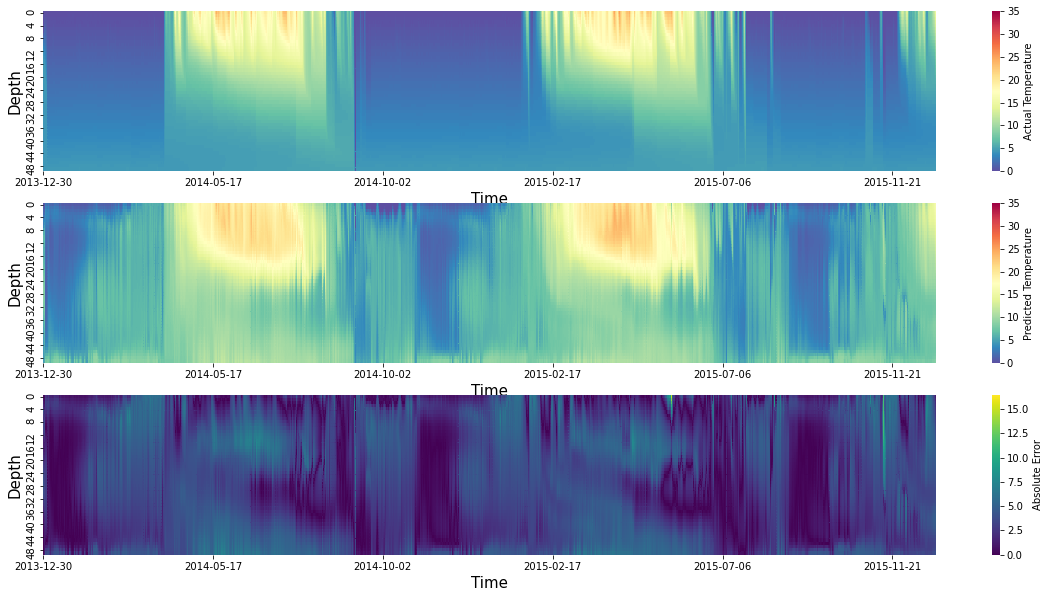

In [19]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

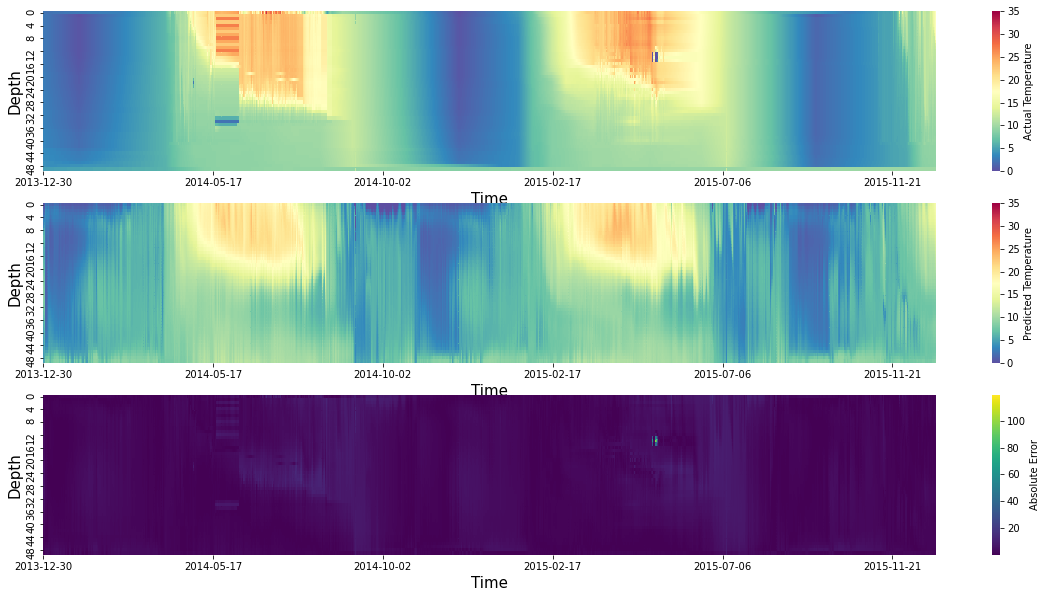

In [20]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

## Test Results

In [21]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(direct_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

RMSE of after m0 4.1894064
RMSE of after m0 4.154988
RMSE of after m0 4.2053843
RMSE of after m0 4.3244715
RMSE of after m0 4.3405886
RMSE of after m0 4.214823
RMSE of after m0 3.9400861
RMSE of after m0 3.8928182
RMSE of after m0 3.9737315
RMSE of after m0 4.081176
RMSE of after m0 4.0146203
RMSE of after m0 3.9865904
RMSE of after m0 4.063253
RMSE of after m0 4.0576954
RMSE of after m0 4.1240077
RMSE of after m0 4.291613
RMSE of after m0 4.3588142
RMSE of after m0 4.354417
RMSE of after m0 4.4178786
RMSE of after m0 4.4680996
RMSE of after m0 4.6624484
RMSE of after m0 4.695584
RMSE of after m0 4.5904884
RMSE of after m0 4.278049
RMSE of after m0 4.399745
RMSE of after m0 4.499427
RMSE of after m0 4.570133
RMSE of after m0 4.588775
RMSE of after m0 4.4611173
RMSE of after m0 4.492069
RMSE of after m0 4.494082
RMSE of after m0 4.5425715
RMSE of after m0 4.6584263
RMSE of after m0 4.5671105
RMSE of after m0 4.695604
RMSE of after m0 4.7024074
RMSE of after m0 4.6753945
RMSE of after m0

RMSE of after m0 2.7246351
RMSE of after m0 3.404114
RMSE of after m0 3.5044525
RMSE of after m0 3.0575755
RMSE of after m0 2.8409495
RMSE of after m0 2.7513256
RMSE of after m0 3.0471063
RMSE of after m0 3.387045
RMSE of after m0 3.7922814
RMSE of after m0 3.7323542
RMSE of after m0 3.4793017
RMSE of after m0 3.3092322
RMSE of after m0 3.422496
RMSE of after m0 3.4548373
RMSE of after m0 3.1707637
RMSE of after m0 3.3085358
RMSE of after m0 3.4627001
RMSE of after m0 4.0348883
RMSE of after m0 4.3361087
RMSE of after m0 4.1768684
RMSE of after m0 4.0291324
RMSE of after m0 4.1303988
RMSE of after m0 4.2848535
RMSE of after m0 4.3389826
RMSE of after m0 4.310579
RMSE of after m0 3.9082472
RMSE of after m0 3.8503222
RMSE of after m0 3.8636742
RMSE of after m0 3.77195
RMSE of after m0 3.5863
RMSE of after m0 3.8372989
RMSE of after m0 4.0413346
RMSE of after m0 4.041369
RMSE of after m0 4.067943
RMSE of after m0 3.9421327
RMSE of after m0 4.169861
RMSE of after m0 4.0934095
RMSE of after

RMSE of after m0 2.8214104
RMSE of after m0 3.313352
RMSE of after m0 3.1668723
RMSE of after m0 3.1534948
RMSE of after m0 3.686928
RMSE of after m0 3.4560769
RMSE of after m0 3.2674048
RMSE of after m0 3.2385368
RMSE of after m0 3.2601647
RMSE of after m0 3.5024219
RMSE of after m0 3.1227202
RMSE of after m0 3.1308613
RMSE of after m0 2.904611
RMSE of after m0 3.554888
RMSE of after m0 3.4916801
RMSE of after m0 3.5691285
RMSE of after m0 3.528252
RMSE of after m0 3.4308722
RMSE of after m0 3.5173721
RMSE of after m0 2.8183436
RMSE of after m0 2.5518918
RMSE of after m0 4.8077526
RMSE of after m0 2.1561985
RMSE of after m0 2.2071612
RMSE of after m0 2.2801378
RMSE of after m0 2.2967627
RMSE of after m0 2.272987
RMSE of after m0 2.3584895
RMSE of after m0 2.5915337
RMSE of after m0 2.577
RMSE of after m0 2.6436384
RMSE of after m0 2.5637038
RMSE of after m0 2.6927574
RMSE of after m0 2.9435978
RMSE of after m0 2.9981813
RMSE of after m0 3.2389479
RMSE of after m0 3.5263982
RMSE of aft

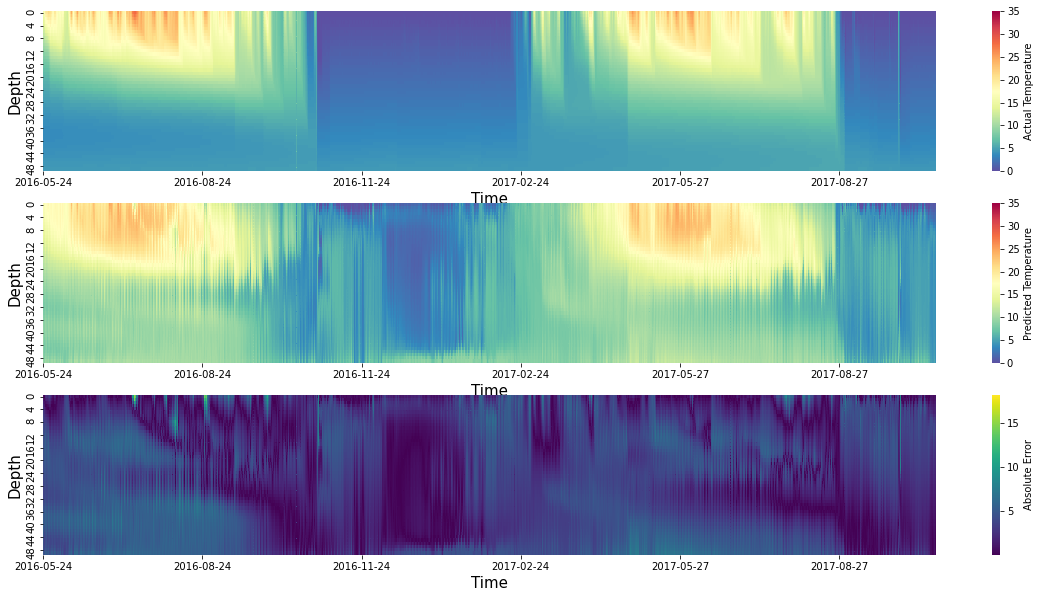

In [22]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

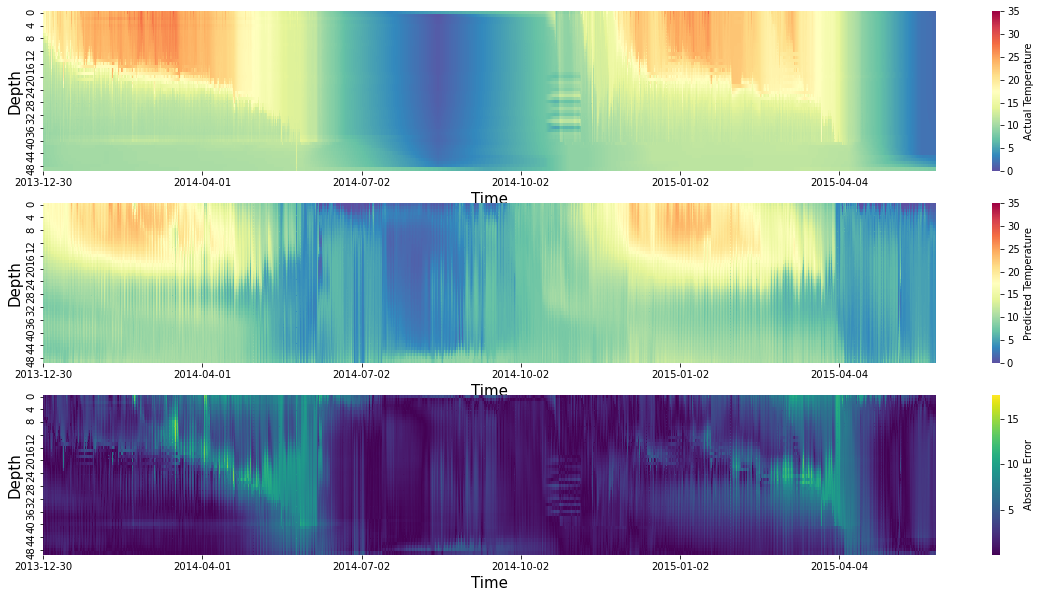

In [23]:
plot_output(test_y_pred, test_y_obs, depth_steps, train_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [24]:
train_rmse, train_l2_err = compute_metrics( direct_model, train_loader, m0_input_column_ix, m0_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(direct_model, test_loader, m0_input_column_ix, m0_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 3.380264534309075, Train L2 Error: 0.48901842554745545
Test RMSE: 3.4494825592335028, Train L2 Error: 0.3987699460389871


## Mixing Model

## Convection Model

## Ice Model

In [25]:
def plot_output_test(y_pred, y_true, depth_steps, time_label, figsize=(20,10)):
    time_label = np.array([time[:10] for time in time_label])
    time_label = time_label[::depth_steps]
    times = time_label
    
    print(times)
    
    y_pred = y_pred.flatten().detach().cpu().numpy()
    y_true = y_true.flatten().detach().cpu().numpy()
    
    y_true = np.reshape(y_true, (y_true.shape[0]//depth_steps, depth_steps))
    y_pred = np.reshape(y_pred, (y_pred.shape[0]//depth_steps, depth_steps))
    
    N_pts = 6 # number of points to display on the x-label
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)


    sns.heatmap(y_pred.T, ax=ax, cmap='Spectral_r', vmin=0., vmax=35.)
    ax.set_ylabel("Depth (m)", fontsize=15)
    ax.set_xlabel("", fontsize=15)
    
    #  plt.legend(fontsize='x-large', title_fontsize='40')
    # ax.xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    # ax.set_xticklabels(time_label, rotation=0)
    # new insert
    xticks_ix = np.array(ax.get_xticks()).astype(int)
    
    print(xticks_ix)
    
    time_label = times[xticks_ix]
    
    print(time_label)
    
    nelement = len(time_label)//N_pts
    
    print(nelement)
    
    time_label = time_label[::nelement]
    
    print(time_label)
    
    ax.xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax.set_xticklabels(time_label, rotation=0, fontsize = 15)
    # old code
    ax.collections[0].colorbar.set_label("Predicted Temperature ($^\circ$C)", fontsize = 15)
    yticks_ix = np.array(ax.get_yticks()).astype(int)
    
    print(yticks_ix)
    
    # depth_label = depth_steps / 25
    depth_label = yticks_ix / 2
    
    print(depth_label)
    
    nelement = len(depth_label)//5
    
    print(nelement)
    
    depth_label = depth_label[::nelement]
    
    print(depth_label)
    
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    ax.set_yticklabels(depth_label, rotation=0, fontsize = 15)

    plt.show()

# Finetuning

['2016-05-24' '2016-05-24' '2016-05-24' ... '2017-12-28' '2017-12-28'
 '2017-12-28']
[    0   187   374   561   748   935  1122  1309  1496  1683  1870  2057
  2244  2431  2618  2805  2992  3179  3366  3553  3740  3927  4114  4301
  4488  4675  4862  5049  5236  5423  5610  5797  5984  6171  6358  6545
  6732  6919  7106  7293  7480  7667  7854  8041  8228  8415  8602  8789
  8976  9163  9350  9537  9724  9911 10098 10285 10472 10659 10846 11033
 11220 11407 11594 11781 11968 12155 12342 12529 12716 12903 13090 13277
 13464 13651 13838]
['2016-05-24' '2016-05-31' '2016-06-08' '2016-06-16' '2016-06-24'
 '2016-07-02' '2016-07-09' '2016-07-17' '2016-07-25' '2016-08-02'
 '2016-08-10' '2016-08-17' '2016-08-25' '2016-09-02' '2016-09-10'
 '2016-09-17' '2016-09-25' '2016-10-03' '2016-10-11' '2016-10-19'
 '2016-10-26' '2016-11-03' '2016-11-11' '2016-11-19' '2016-11-26'
 '2016-12-04' '2016-12-12' '2016-12-20' '2016-12-28' '2017-01-04'
 '2017-01-12' '2017-01-20' '2017-01-28' '2017-02-05' '2017-02

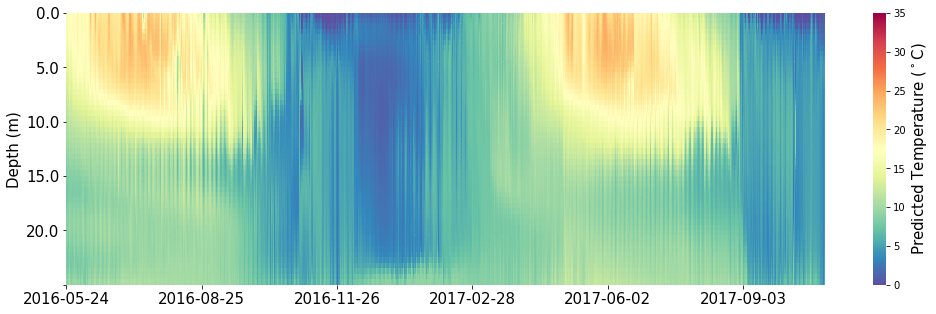

In [26]:
plot_output_test(test_y_pred, test_y_obs, depth_steps, test_time, figsize=(17,5))